# Proyecto del tercer parcial: Segmentación de documentos

### Por: Vanessa Martínez Romero y Fernando Gómez Perera

El presente reporte tiene como objetivo explicar y ejemplificar el aprendizaje no supervisado a partir de un ejemplo de segmentación de documentos.

In [1]:
# Paquetes para la limpieza del texto
from spacy.lang.en import English
import unicodedata

# Paquetes para la creacion de la nube de palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Paquetes para aplicar el modelo de aprendizaje no supervisado
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import numpy as np

# Paquetes auxiliares
import os

# Analizador morfologico del idioma ingles
nlp = English()

## Introducción

### Aprendizaje no supervisado

El objetivo de esta técnica es descubrir patrones en un conjunto de datos, sin que estos tengan alguna etiqueta o identificador explícito que permita agruparlos de alguna forma.

La técnica de aprendizaje no supervisado aplicada a la segmentación de documentos permite agrupar documentos en tópicos a partir del contenido de cada documento. Para ello, hay que pre-procesar el texto dentro de cada documento para que el modelo pueda encontrar patrones útiles usando los términos presentes en cada uno de ellos.

Para este ejercicio, se tomarán diferentes artículos del *International Journal of Machine Learning and Computing*, y se pre-procesará su contenido para poder agruparlos.

### Algoritmo *K-Medias* o *K-Means*

Este algoritmo de *aprendizaje no supervisado* tiene como objetivo agrupar (en inglés: *cluster*) datos tratando de separarlos en n grupos de igual varianza. Específicamente, este algoritmo divide un set de $N$ muestras (llamado $X$) en $K$ grupos (clústeres) disjuntos (cuyo conjunto se denomina $C$), cada uno descrito por la media $\mu_j$ de las muestras dentro del clúster. A estas medias se les conoce también como los *centroides* de los clústeres, los cuales no son necesariamente puntos dentro de $X$, pero sí existen dentro de su mismo espacio.

El objetivo de *K-Means* es minimizar el criterio conocido como *inertia* o *within-cluster sum-of-squares*, que simplemente es una medida que indica qué tan coherentes son los clústeres internamente. Para ello, el algoritmo elige los centroides que minimicen este criterio por medio de la siguiente fórmula:

$$\sum_{i=0}^{n}\min_{\mu_j\in{C}}(||x_i-\mu_j||^2)$$

El resultado de aplicar este algoritmo a la segmentación de documentos será encontrar $k$ clústeres agrupados de acuerdo a los términos presentes dentro de los documentos.

In [2]:
# Lectura de los articulos
texts = list()

for filename in os.listdir('corpus'):
    with open('corpus/' + filename, 'rb') as file:
        texts.append(file.read().decode())
        
print("Total de artículos: ", len(texts))

Total de artículos:  556


El paquete `SpaCy` permitirá pre-procesar el contenido de los artículos usando técnicas de Procesamiento de Lenguaje Natural. De esta forma, será posible limpiar cada artículo eliminando los elementos que no son de utilidad para este análisis, como las *stop words* o los caracteres no-ASCII.

In [3]:
# Pipeline de SpaCy para pre-procesar la lista de documentos
docs = list(nlp.pipe(texts))

In [4]:
"""Funcion para limpiar cada documento, y regresar un doc en su forma original o lematizado"""
def clean_text(doc, lemma=False):
    text = list()
    for token in doc:
        # Filtrado de los tokens con caracteres no-ASCII y que se identifican como stop words
        if token.is_ascii and not(token.is_stop):
            # La funcion puede regresar el documento en su forma original o lematizado
            # En ambos casos, solamente se quedan los caracteres del token que son letras minusculas
            if lemma:
                token_clean = [char for char in token.lemma_.lower() \
                               if unicodedata.category(char) == 'Ll']
            else:
                token_clean = [char for char in token.lower_ \
                               if unicodedata.category(char) == 'Ll']
            if len(token_clean) > 0:
                text.append(''.join(token_clean))
    return ' '.join(token for token in text)

Se realizarán dos tipos de segmentación de documentos: Una con los documentos en su forma original, y otra con los documentos lematizados. La **lematización** permite convertir las palabras de los documentos en su forma base llamada **lema**, que es la forma en la que aparecen dentro de los diccionarios.

>Ejemplo con las variantes de la palabra *have* :

In [5]:
lemma_ex = nlp('have has had having he\'s')
for token in lemma_ex:
    print(token.lemma_)

have
have
have
have
-PRON-
have


Este ejemplo permite visualizar la forma en la que `SpaCy` convierte las variantes de las palabras a su lema *have*, disminuyendo la dispersión de los términos presentes en los documentos al agrupar los términos que provengan del mismo lema.

In [6]:
# Corpus con los documentos en su forma original
corpus_orig = [clean_text(doc) for doc in docs]
# Corpus con los documentos lematizaados
corpus_lemma = [clean_text(doc, lemma=True) for doc in docs]

## Nube de palabras

Se usará el paquete `WordCloud` para crear una imagen con la nube de palabras con los términos más frecuentes tanto en el *corpus* con los términos en su forma original como en el *corpus* con los términos lematizados.

### Con los documentos en su forma original

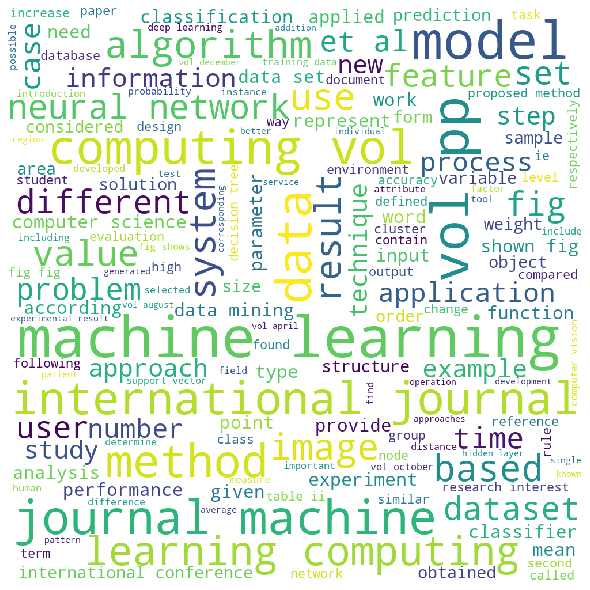

In [7]:
wordcloud = WordCloud(width = 1000, height = 1000, 
                      background_color ='white',
                      min_font_size = 12).generate(' '.join(corpus_orig))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Con los documentos lematizados

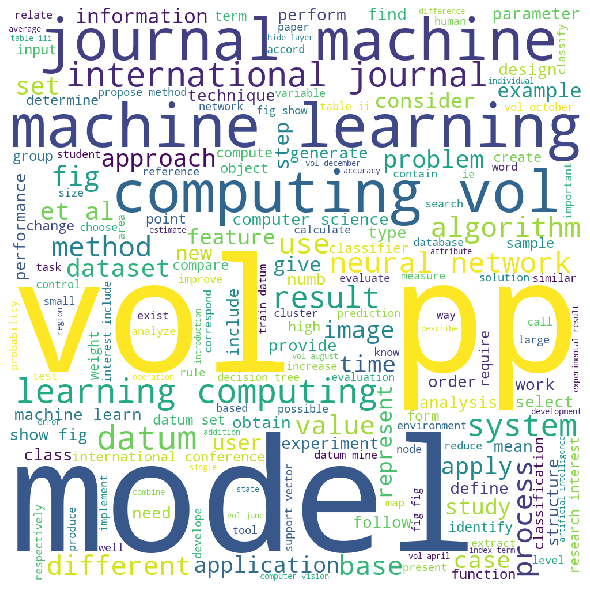

In [8]:
wordcloud = WordCloud(width = 1000, height = 1000, 
                      background_color ='white',
                      min_font_size = 12).generate(' '.join(corpus_lemma))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

En ambos casos, los resultados se ven completamente diferentes. Con los documentos originales, el tamaño de las palabras se mantiene masomenos constante, indicando una menor variación entre la cantidad de veces que se repiten los términos comúnes. Sin embargo, con los documentos lematizados, ciertos términos destacan de forma considerable del resto de términos, esto como consecuencia del proceso de lematización.

## Agrupamiento

### Transformación de las características para su análisis

Para poder agrupar los documentos usando *K-Means* es necesario extraer, en primera instancia, características o *features* numéricos a partir de los términos presentes en los documentos. A este proceso se le conoce como *vectorización*, y para llevarlo a cabo se usará el modelo *Bag of Words* (en español: *bolsa de palabras*), con el cual será posible también normalizar el peso de la frecuencia de los términos dentro de los documentos usando la *matriz de frecuencia inversa de documentos* (en inglés: *term-frequency times inverse document-frecuency* o *tf-idf*).

#### Modelo *Bag of Words*

Esta estrategia está compuesta de una serie de transformaciones realizadas sobre el texto, con el objetivo de extraer *features* numéricos a partir de él, ignorando la posición relativa de los términos dentro de los documentos. Está compuesto de las siguientes transformaciones:

* **Tokenización** del texto.
* **Conteo** de las ocurrencias de los tokens en cada documento.
* **Normalización** y ponderación de los tokens de acuerdo a su presencia en la mayoría de las muestras / documentos.

En este modelo, los *features* y las muestras / documentos se definen de la siguiente forma:
* Cada valor de frecuencia individual de un token (normalizado o no) se toma como un *feature*.
* El vector con todos los valores de frecuencia de token para un documento específico se considera como una muestra multivariada.

De esta forma, es posible obtener una matriz donde cada documento representa una fila, y cada token (en este caso, término) representa una columna.

#### Matriz de frecuencia inversa de documentos o *tf-idf*

Usando *bag of words* es posible obtener una matriz donde los valores representen la cantidad de veces que el término aparece en cada documento. A esta matriz se le conoce como la *matriz término-documento* (en inglés: *term-document*). Sin embargo, tomar los valores de esta matriz para encontrar patrones sería poco conveniente, pues el peso de cada término aumenta de acuerdo a su presencia dentro de cada documento. Esto tiene como consecuencia que el valor de los términos con menor aparición dentro de los documentos, los cuáles pueden llegar a ser incluso más importantes para definir la segmentación de documentos, se vean opacados. Por lo tanto, normalizar los valores de esta matriz resulta de suma importancia.

Para ello, se hace uso de la *matriz de frecuencia inversa de documentos* o *tf-idf*. Con esta matriz, los valores de frecuencia se penalizan conforme el término aparece más veces en los documentos, y son mayores si el término es menos frecuente.

#### Transformación

`scikit-learn` permite aplicar de forma sencilla ambas operaciones al mismo tiempo por medio de la clase `TfidVectorizer`. Esta clase permite vectorizar los términos y obtener la matriz *tf-idf* en un solo paso.

Tanto el *corpus* con los términos en su forma original, como el *corpus* con los términos lematizados, son transformados usando esta clase.

In [9]:
# Corpus con los terminos en su forma original
vectorizer_orig = TfidfVectorizer()
X_orig = vectorizer_orig.fit_transform(corpus_orig)
X_orig

<556x46868 sparse matrix of type '<class 'numpy.float64'>'
	with 437484 stored elements in Compressed Sparse Row format>

In [10]:
# Corpus con los terminos lematizados
vectorizer_lemma = TfidfVectorizer()
X_lemma = vectorizer_lemma.fit_transform(corpus_lemma)
X_lemma

<556x43179 sparse matrix of type '<class 'numpy.float64'>'
	with 388814 stored elements in Compressed Sparse Row format>

Una pequeña muestra de la matriz *tf-idf* obtenida a partir del *corpus* con los términos en su forma original se muestra a continuación.

In [11]:
# Terminos a visualizar en la matriz tf-idf
vectorizer_orig.get_feature_names()[205:210]

['abstain', 'abstinence', 'abstract', 'abstracted', 'abstracting']

In [12]:
# Muestra de la matriz tf-idf de los primeros 2 documentos
X_orig.toarray()[0:2, 205:210]

array([[0.        , 0.        , 0.00269914, 0.        , 0.        ],
       [0.        , 0.        , 0.00258001, 0.        , 0.        ]])

### Reducción de dimensionalidad usando LSA

Aún seguimos teniendo un problema importante con los resultados de ambas matrices. Y es que ambas tienen dimensiones enormes, de más de 40,000 términos.

Como se mencionó al principio del documento, *K-Means* usa la medida de *within-cluster sum-of-squares (WSS)* para elegir los centroides de los clústers. Sin embargo, esta medida tiende a inflar los valores de distancia en dimensionalidades altas. Por lo que resulta necesario reducir la dimensionalidad de ambas matrices.

Usando la técnica de *Análisis Semántico Latente* o *Latent Semantic Analysis (LSA)*, es posible analizar las relaciones entre un set de documentos y los términos que contienen, obteniendo un set de conceptos relacionados a estos documentos y términos, asumiendo que las palabras que se encuentran cercanas en significado ocurrirán en piezas similiares del texto (conocido como *semántica distribucional*). De esta forma, LSA, además de permitir la reducción de dimensionalidad, permite descubrir patrones latentes en los datos.

LSA usa la *Descomposición en valores singulares truncada (Truncated Singular Value Decomposition o Truncated SVD)* para reducir el número de dimensiones sobre matrices de tipo *term-document* o *tf-idf* (que son las que usamos para caracterizar los documentos).

Usar LSA implica elegir el número de componentes a preservar. Para ello, se elige el número total de componentes que permitan preservar, como mínimo, el 75% de la varianza total de los datos.

#### Con los documentos en su forma original

Número de componentes a elegir:  284
Varianza total explicada:  0.7511558573635078


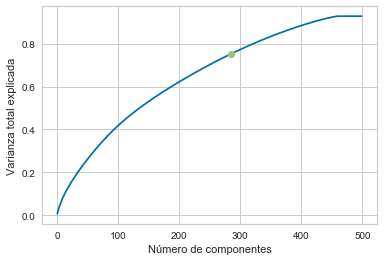

In [13]:
# Numero de componentes a elegir para LSA
svd = TruncatedSVD(n_components=500) # 500 como tope maximo de componentes
svd.fit(X_orig.toarray())

X_svd = np.cumsum(svd.explained_variance_)

for i, cum_ev in enumerate(X_svd):
    if cum_ev >= 0.75:
        print("Número de componentes a elegir: ", i)
        print("Varianza total explicada: ", cum_ev)
        svd_comp = [i, cum_ev]
        break

plt.plot(X_svd)
plt.plot(svd_comp[0], svd_comp[1], marker="o")
plt.xlabel('Número de componentes')
plt.ylabel('Varianza total explicada') 
plt.show()

# Reduccion de dimensionalidad
# Los resultados vectorizados son normalizados. Esto permite que K-Means se comporte
# de forma esférica para obtener mejores resultados. Los resultados de LSD/SVD
# no se encuentran normalizados, por lo que hay que repetir esta normalización.
# Por ello, ambas funciones se ponen dentro de un pipeline.
svd_orig = TruncatedSVD(n_components=svd_comp[0])
normalizer_orig = Normalizer(copy=False)
lsa_orig = make_pipeline(svd_orig, normalizer_orig)
X_orig_lsa = lsa_orig.fit_transform(X_orig.toarray())

#### Con los documentos lematizados

Número de componentes a elegir:  278
Varianza total explicada:  0.7509646369408552


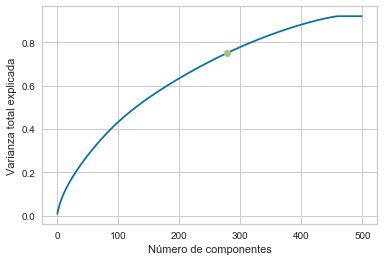

In [14]:
# Numero de componentes a elegir para LSA
svd = TruncatedSVD(n_components=500) # 500 como tope maximo de componentes
svd.fit(X_lemma.toarray())

X_svd = np.cumsum(svd.explained_variance_)

for i, cum_ev in enumerate(X_svd):
    if cum_ev >= 0.75:
        print("Número de componentes a elegir: ", i)
        print("Varianza total explicada: ", cum_ev)
        svd_comp = [i, cum_ev]
        break

plt.plot(X_svd)
plt.plot(svd_comp[0], svd_comp[1], marker="o")
plt.xlabel('Número de componentes')
plt.ylabel('Varianza total explicada') 
plt.show()

# Reduccion de dimensionalidad
# Los resultados vectorizados son normalizados. Esto permite que K-Means se comporte
# de forma esférica para obtener mejores resultados. Los resultados de LSD/SVD
# no se encuentran normalizados, por lo que hay que repetir esta normalización.
# Por ello, ambas funciones se ponen dentro de un pipeline.
svd_lemma = TruncatedSVD(n_components=svd_comp[0])
normalizer_lemma = Normalizer(copy=False)
lsa_lemma = make_pipeline(svd_lemma, normalizer_lemma)
X_lemma_lsa = lsa_lemma.fit_transform(X_lemma.toarray())

### Elección de `k` para la aplicación del algoritmo

Finalmente, los datos ya transformados están listos para usarse con el algoritmo de `K-Medias`.

Como ya se mencionó al principio del documento, para elegir el número de `k` adecuado será necesario evaluar la *inercia* o *within-cluster sum-of-squares (WSS)*, para que el algoritmo elija los centroides que minimicen este criterio. Finalmente, `K-Means` tendrá como resultado los cluster agrupados de acuerdo a los términos que están presentes en los documentos.

De igual forma, a la evaluación de la *inercia* o *WSS* se le conoce como el *método del codo* o *Elbow Method*.

#### Con los documentos en su forma original

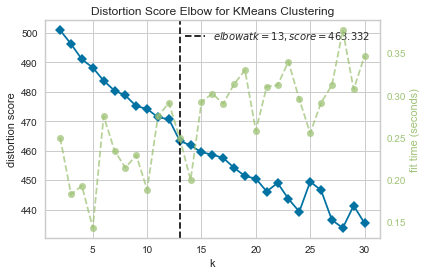

In [20]:
# Se prueba con un maximo de k de 30
kmeans = KElbowVisualizer(KMeans(), k=30)

kmeans.fit(X_orig_lsa)
kmeans.show()

Con los documentos en su forma original, el *Elbow Method* encuentra un valor de `k` igual a 13.

#### Con los documentos lematizados

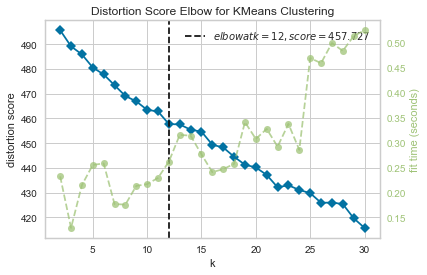

In [18]:
# Se prueba con un maximo de k de 30
kmeans = KElbowVisualizer(KMeans(), k=30)

kmeans.fit(X_lemma_lsa)
kmeans.show()

Con los documentos lematizados, el *Elbow Method* encuentra un valor de `k` igual a 12.

### Aplicación del algoritmo *K-Means* a ambos casos

Con los valores de `k` encontrados, finalmente se aplica el algoritmo sobre ambos casos.

In [22]:
# Con los documentos en su forma original
kmeans_orig = KMeans(n_clusters=13)
kmeans_orig.fit(X_orig_lsa)
centroids_orig = kmeans_orig.cluster_centers_
pred_clusters_orig = kmeans_orig.predict(X_orig_lsa)

# Con los documentos lematizados
kmeans_lemma = KMeans(n_clusters=12)
kmeans_lemma.fit(X_lemma_lsa)
centroids_lemma = kmeans_lemma.cluster_centers_
pred_clusters_lemma = kmeans_lemma.predict(X_lemma_lsa)

## Resultados

Finalmente, es posible analizar cada grupo a partir de su representa (su centroide).

### Con los documentos en su forma original

In [34]:
# Transformacion de los centroides a su dimension original
centroids_trans = svd_orig.inverse_transform(centroids_orig)
# Identificacion de los 10 terminos mas frecuentes en cada representante de grupo
order_centroids = centroids_trans.argsort()[:, ::-1]
terms = vectorizer_orig.get_feature_names()
for i in range(13):
    print("Cluster " + str(i+1) + ":", end='')
    for j in order_centroids[i, :10]:
        print(' %s' % terms[j], end='')
    print()

Cluster 1: fuzzy membership echo data rules anomalous rule model emissions forecasting
Cluster 2: cid image cidcid shadow images detection smoothing forgery polar waveform
Cluster 3: data tree model learning vol mining decision algorithm patients prediction
Cluster 4: sentiment word words tweets tweet data twitter features crfs model
Cluster 5: feature features data classification learning recognition classifier som method based
Cluster 6: algorithm system data based vol fig learning search information time
Cluster 7: face facial recognition image images feature emotion detection expression faces
Cluster 8: quantum data sparse algorithm nmf formalin vol matrix projections fig
Cluster 9: data learning layer neural network training model deep classification networks
Cluster 10: robot control policy agent learning controller reinforcement rl environment gait
Cluster 11: user users recommendation device system items recommender social item information
Cluster 12: cloud service storage data

En este caso, los términos presentes en los 13 clústers dan una idea sobre los temas en los que se clasificaron, unos más claros que otros.

Por ejemplo:
* El clúster 4 presenta términos relacionados a análisis de sentimientos sobre tweets.
* El clúster 5 presenta términos relacionados a la clasificación de datos a partir del reconocimiento de patrones.
* El clúster 9 presenta términos relacionados al deep learning y las redes neuronales.
* El clúster 11 presenta términos relacionados a los sistemas de recomendaciones.
* El clúster 12 presenta términos relacionados a la seguridad en el cloud computing.

### Con los documentos lematizados

In [36]:
# Transformacion de los centroides a su dimension original
centroids_trans = svd_lemma.inverse_transform(centroids_lemma)
# Identificacion de los 10 terminos mas frecuentes en cada representante de grupo
order_centroids = centroids_trans.argsort()[:, ::-1]
terms = vectorizer_lemma.get_feature_names()
for i in range(12):
    print("Cluster " + str(i+1) + ":", end='')
    for j in order_centroids[i, :10]:
        print(' %s' % terms[j], end='')
    print()

Cluster 1: cluster datum algorithm quantum fuzzy vol set method result fig
Cluster 2: robot sensor agent node device system learn environment fig action
Cluster 3: feature layer network image train datum neural model learn dataset
Cluster 4: tweet twitter social post sentiment earthquake word user topic movie
Cluster 5: datum tree dataset class classification gene method algorithm rule model
Cluster 6: gesture hand recognition feature rgb depth frame video cd image
Cluster 7: user word document datum cloud system query service information model
Cluster 8: algorithm particle solution optimization pso genetic population function swarm search
Cluster 9: face image facial recognition feature detection expression eye camera object
Cluster 10: model forecast datum wavelet arima elm wind time energy signal
Cluster 11: image segmentation pixel method texture shadow region feature fig blood
Cluster 12: item itemset virus itemsets user frequent path algorithm rule recommendation


En este caso, los términos presentes en los 12 clústers dan una idea sobre los temas en los que se clasificaron. En este caso, como los términos se encuentran lematizados, los términos se encuentran en su forma base.

Por ejemplo:
* El clúster 3 presenta términos relacioandos al deep learning y las redes neuronales.
* El clúster 4 presenta términos relacionados a análisis de sentimientos sobre tweets.
* El clúster 6 presenta términos relacionados al reconocimiento de patrones en textos a mano
* El clúster 9 presenta términos relacionados al reconocimiento de imágenes faciales.
* El clúster 11 presenta términos relacionados a la segmentación de imágenes.

Dependiendo de como sea necesario analizar el texto, puede resultar de mayor ayuda tener los términos lematizados o en su forma original.

## Referencias

* scikit-learn developers. (s.f.). *Clustering*. Documento recuperado el 04 de diciembre del 2019. Disponible en: https://scikit-learn.org/stable/modules/clustering.html#k-means
* scikit-learn developers. (s.f.). *Feature extraction*. Documento recuperado el 04 de diciembre del 2019. Disponible en: https://scikit-learn.org/stable/modules/feature_extraction.html
* scikit-learn developers. (s.f.). *Decomposing signals in components (matrix factorization problems)*. Documento recuperado el 04 de diciembre del 2019. Disponible en: https://scikit-learn.org/stable/modules/decomposition.html#pca
* Wikipedia (s.f.). *Latent semantic analysis*. Documento recuperado el 07 de diciembre de 2019. Disponible en: https://en.wikipedia.org/wiki/Latent_semantic_analysis
* scikit-learn developers. (s.f.). *Clustering text documents using k-means*. Documento recuperado el 07 de diciembre del 2019. Disponible en: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html